In [12]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels_rerun'

r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
    save_dir, include_losses=True, do_reranking=True, save_file='r.pkl')

getting dir_names...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.83it/s]


In [24]:
min([len(L) for L in all_losses])

62

In [25]:
top_prompts = (
    r.groupby(['task_name', 'seed', 'max_digit'])
).first().reset_index()
top_prompts[['task_name', 'seed', 'max_digit', 'prefixes', 'reciprocal_rank']]

,task_name,seed,max_digit,prefixes,reciprocal_rank
0,add_two,1,10,Add two integers together to arrive,1.000000
1,add_two,1,40,Add two positive integers together to,1.000000
2,add_two,1,80,Add two integers together to get,1.000000
3,add_two,1,160,Add two integers together to get,1.000000
4,add_two,2,10,Write a function to add together,1.000000
...,...,...,...,...,...
67,subtract_two,2,40,What number can you subtract from,1.000000
68,subtract_two,2,80,The next number in a series,0.076923
69,subtract_two,2,160,How do you subtract a number,1.000000
70,subtract_two,3,10,Use your function to compute each,0.055556


<AxesSubplot:ylabel='max_digit'>

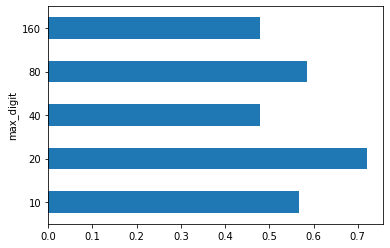

In [26]:
top_prompts.groupby('max_digit').mean()['reciprocal_rank'].plot(kind='barh')

In [27]:
top_prompts['reciprocal_rank'].mean()

0.5636972341906694

In [20]:
assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"

In [21]:
from iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

KeyboardInterrupt: 

In [ ]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 16

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

for _, output in tqdm(top_prompts.iterrows(), total=len(top_prompts)):
    args = argparse.Namespace(**output)
    (dset, dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=n_shots, train_split_frac=args.train_split_frac,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
        max_digit=args.max_digit,
    )
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   Manual prompt  ####
    manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####   iPrompt prompt   ####
    iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####
    output['manual_acc'] = manual_acc
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

In [21]:
output['prefixes']

' Given n positive integers that add'

In [24]:
import os

# top_prompts_df = pd.DataFrame(data)
# top_prompts_df.to_pickle(os.path.join(save_dir, 'top_prompts.pkl'))
top_prompts_df = pd.read_pickle(os.path.join(save_dir, 'top_prompts.pkl'))

In [25]:
top_prompts_df['prompt_ratio'] = top_prompts_df['manual_acc'] / top_prompts_df['iprompt_acc']

In [56]:
top_prompts_df.groupby(['task_name', 'max_digit']).mean()['manual_acc']

task_name      max_digit
add_two        10            76.444444
               20            56.666667
               40            48.833333
               80            32.000000
               160           10.866667
divide_two     10            10.666667
               20             3.666667
               40             3.916667
               80             5.133333
               160            8.866667
double_one     10           100.000000
               20           100.000000
               40            96.666667
               80            95.000000
               160           71.666667
exp_one        10            14.285714
               20            13.333333
               40             3.333333
               80            10.000000
               160           10.000000
fibonacci_one  10            71.428571
               20            20.000000
               40            13.333333
               80             3.333333
               160            5.833333


<AxesSubplot:xlabel='max_digit', ylabel='manual_acc'>

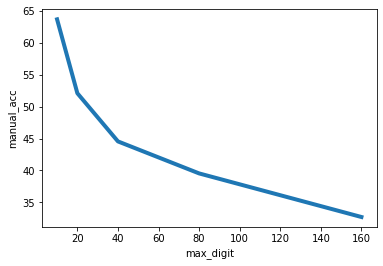

In [62]:
task_acc_percent = ((
            top_prompts_df.groupby(['max_digit']).mean()
        ) 
        / 
        (1 
            # top_prompts_df.groupby(['task_name']).max()['manual_acc'] - top_prompts_df.groupby(['task_name']).min()['manual_acc']
        )
).reset_index()

# task_acc_percent = task_acc_percent[
#     task_acc_percent['task_name'].map(lambda s: s not in [''])
# ]

sns.lineplot(data=task_acc_percent, x='max_digit', y='manual_acc', linewidth=4)

In [68]:
sns.lineplot(data=task_acc_percent, x='max_digit', y=['manual_acc', 'iprompt_acc'], linewidth=4)

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 5 and the vector passed to `y` has length 2.

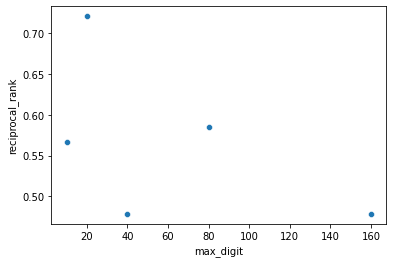

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

r_grouped_by_task = (
    top_prompts
     .groupby(['max_digit']).mean()
     .reset_index()
)

ax = sns.scatterplot(
    data=r_grouped_by_task, x='max_digit', y='reciprocal_rank', # hue='task_name',
)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # legend outside of plot
# ax.set_yscale('log')

In [39]:
top_prompts[top_prompts['reciprocal_rank'] > 0.1][['prefixes','reciprocal_rank','task_name']]

,prefixes,reciprocal_rank,task_name
0,Add two integers together to arrive,1.000000,add_two
1,Add two positive integers together to,1.000000,add_two
2,Add two integers together to get,1.000000,add_two
3,Add two integers together to get,1.000000,add_two
4,Write a function to add together,1.000000,add_two
5,Add two natural number inputs together,1.000000,add_two
6,Add Two Numbers together in Java,1.000000,add_two
7,n / f(x),0.333333,divide_two
8,6> > Given a fraction,0.333333,divide_two
9,This program will divide any two,1.000000,divide_two


## Plot losses

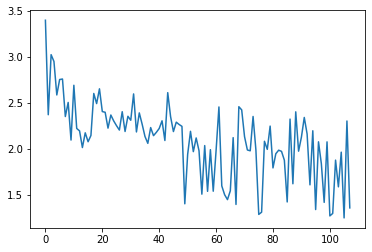

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


plt.plot(np.array(all_losses[20]))